In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

Load testing set

In [3]:
x_test = np.load('../processed_data/x_test_' + wireplane + '.npy')
y_test = np.load('../processed_data/y_test_AE_' + wireplane + '.npy')
mean = np.load('../latest_models/mean_' + wireplane + '_nu.npy')
std = np.load('../latest_models/scale_' + wireplane + '_nu.npy')

In [4]:
x_test_scaled = (x_test-mean)/std

DEBUG START

In [5]:
y_test_scaled = []
for i in range(len(y_test)):
    if sum(y_test[i]) == 0:
        y_test_scaled.append(y_test[i])
    else:
        scaled = (y_test[i]-mean)/std
        y_test_scaled.append(scaled)
y_test_scaled = np.array(y_test_scaled)


DEBUG END

Load trained model

In [6]:
autoencoder = load_model('../latest_models/model_AE_' + wireplane + 'plane_nu.h5')

In [7]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 7s 8ms/step - loss: 0.0588


0.0588211715221405

### let's see what the MSE is at the region where signal exists

In [8]:
%%time
prediction = autoencoder.predict(x_test_scaled, batch_size=4096)
prediction = prediction.reshape(prediction.shape[0], prediction.shape[1])

25/25 [==============================] - 1s 16ms/step
Wall time: 753 ms


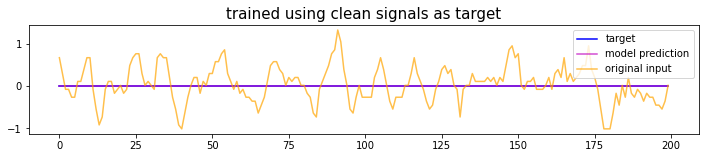

0.00819888524711132
9.313226e-10


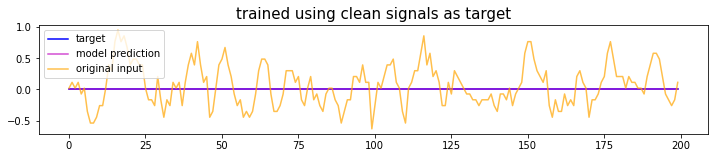

0.00819888524711132
9.313226e-10


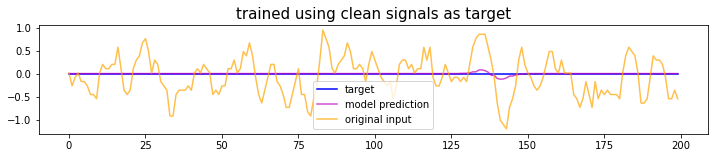

0.0065303410496562716
0.019899871


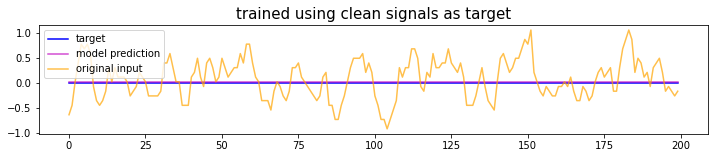

0.00819888524711132
9.313226e-10


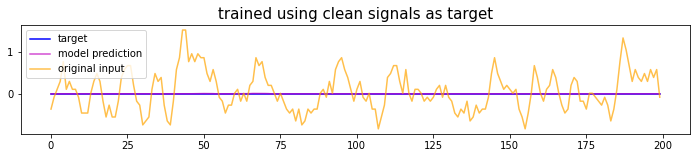

0.008694410109892487
0.0016223234


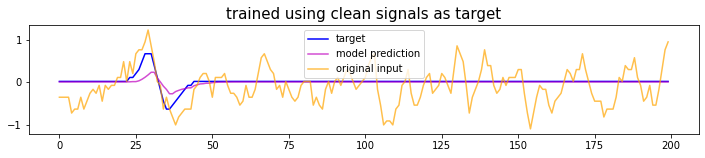

0.0018110986449755729
0.052643217


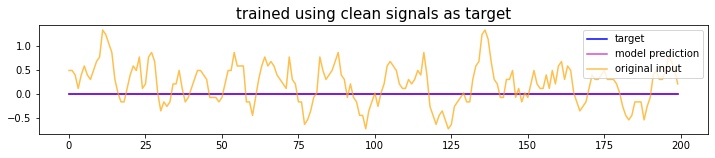

0.00819888524711132
9.313226e-10


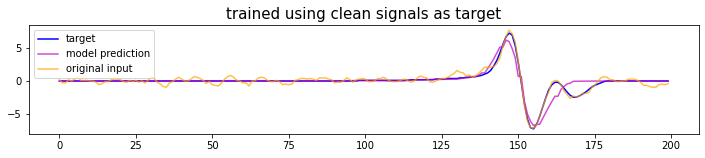

-0.005970779038034379
1.5809207


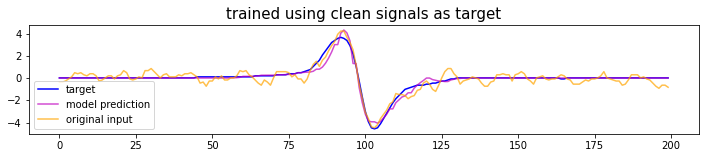

-0.0537685546791181
1.1207217


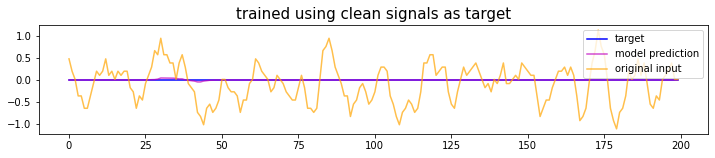

0.008986146454699338
0.009548938


In [10]:
for idx in range(10):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(y_test_scaled[idx],color='blue', label='target')
    ax1.plot(prediction[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test_scaled[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=15)
    ax1.legend()
    

    plt.show()
    print(sum(prediction[idx])/len(prediction[idx]))
    print(prediction[idx].std())

Checkpoint reached

In [ ]:
# calculate MSE for the entire range
mse = np.mean((y_test_scaled - prediction)**2)
print("MSE for entire range:", mse)

In [ ]:
def find_peak_range(array):
    # find the peak and trough of the wave
    peak_indexes = np.argwhere(array == np.amax(array))
    trough_indexes = np.argwhere(array[peak_indexes[0][0]:] == np.amin(array[peak_indexes[0][0]:])) + peak_indexes[0][0]

    peak_ranges = []
    for peak_index, trough_index in zip(peak_indexes, trough_indexes):
        # find the start and end of the peak range
        start_index = peak_index - 1
        while start_index > 0 and array[start_index] > 0:
            start_index -= 1
        end_index = trough_index + 1
        while end_index < len(array) and array[end_index] < 0:
            end_index += 1

        peak_ranges.append([int(start_index), int(end_index)])

    return peak_ranges

In [ ]:
for i in range(10):
    